In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance_matrix

import warnings
warnings.filterwarnings("ignore")

In [70]:
class SpatialFieldSimulator:
    def __init__(self, sqrt_n):
        self.sqrt_n = sqrt_n
        self.grid = self.generate_regular_grid(sqrt_n)
        self.distances_matrix = distance_matrix(self.grid, self.grid)
    
    def simulate(self, method='turning_bands', **args):
        """
        Simula campos aleatorios espaciales gaussianos isotrópicos utilizando diferentes métodos.

        Args:
            method (str): El método a utilizar ('cholesky' o 'turning_bands').
            **args: Argumentos adicionales específicos para cada método.

        Returns:
            numpy.ndarray: Un array que contiene la simulación del campo aleatorio espacial.

        Raises:
            ValueError: Si el método no es válido.

        Esta función permite simular campos aleatorios espaciales utilizando diferentes métodos,
        como Cholesky o Turning Bands.
        """        
        if method not in ['cholesky', 'turning_bands']:
            raise ValueError("Método no válido. Los métodos permitidos son: ['cholesky', 'turning_bands']")
        
        if method == 'cholesky':
            return self.cholesky(**args)
        else:
            return self.turning_bands(**args)
    
    def cholesky(self, model='exponential', **args):
        """
        Simula campos aleatorios espaciales utilizando el método de la 
        descomposición de Cholesky con un modelo de covarianza isotrópico específico.

        Args:
            model (str): El modelo de covarianza a utilizar.
            **args: Argumentos adicionales específicos para el modelo de covarianza.

        Returns:
            numpy.ndarray: Un array que contiene la simulación del campo aleatorio espacial.

        Raises:
            ValueError: Si el modelo de covarianza no es válido.

        Modelos de covarianza permitidos:
        - 'exponential': Modelo exponencial de covarianza.
        - 'powered_exponential': Modelo exponencial potencia de covarianza.
        - 'spheric': Modelo esférico de covarianza.
        - 'askey': Modelo de covarianza Askey.

        Ejemplo de uso:
        ```
        model = 'exponential'
        args = {'alpha': 0.5}
        simulated_field = spatial_simulator.cholesky(model, **args)
        ```
        """
        models = {
            'exponential': self.exponential,
            'powered_exponential': self.powered_exponential,
            'spheric': self.spheric,
            'askey': self.askey
        }
        
        if model not in models:
            raise ValueError(f"Modelo de covarianza no válido. Los modelos permitidos son: {list(models.keys())}")
        
        cov = models[model](**args)
        cholesky_matrix = np.linalg.cholesky(cov(self.distances_matrix))
        random_samples = np.random.normal(0, 1, self.sqrt_n**2)
        
        return cholesky_matrix @ random_samples
    
    def turning_bands(self, L=1_000):
        return
        
    def variogram(self, values, h_max, n_lags=10):
        """
        Calcula el variograma a partir de un vector unidimensional de valores.

        Args:
            values (numpy.ndarray): Vector unidimensional de valores a partir de los cuales se calcula el variograma.
            h_max (float): Máxima distancia de lag a considerar en el variograma.
            n_lags (int, optional): Número de lags en los que se divide el rango de distancia. Valor predeterminado es 10.

        Returns:
            numpy.ndarray: Un array de lags (distancias) y semivariogramas calculados.

        Esta función calcula el variograma a partir de un vector de valores y devuelve los lags y los semivariogramas calculados.
        """
        lags, step = np.linspace(0, h_max, n_lags, retstep=True)
        semivariograms = np.zeros(n_lags)
        
        for i in range(n_lags):
            lag = lags[i]
            lag_lower_bound = lag - step
            
            lag_indices = np.where((self.distances_matrix > lag_lower_bound) & (self.distances_matrix <= lag))
            
            if lag_indices[0].size > 0:
                valid_pairs = values[lag_indices[0]] - values[lag_indices[1]]
                semivariograms[i] = 0.5 * np.mean(valid_pairs ** 2)
        
        return lags, semivariograms

    @staticmethod
    def generate_regular_grid(sqrt_n):
        """
        Genera una cuadrícula de puntos regularmente espaciados en un cuadrado.

        Args:
            sqrt_n (int): El número de puntos a lo largo de cada dimensión.

        Returns:
            numpy.ndarray: Un array 2D que contiene los puntos de la cuadrícula.
            
        Raises:
            ValueError: Si sqrt_n no es un entero positivo.

        La función genera sqrt_n^2 puntos regularmente espaciados en el cuadrado [1, sqrt_n] x [1, sqrt_n].
        Los puntos están ordenados de izquierda a derecha y de abajo hacia arriba.
        """

        if not isinstance(sqrt_n, int) or sqrt_n <= 0:
            raise ValueError("sqrt_n debe ser un entero positivo")

        xx = np.linspace(1, sqrt_n, sqrt_n)
        X, Y = np.meshgrid(xx, xx)
        return np.column_stack((X.flatten(), Y.flatten()))

    @staticmethod    
    def exponential(alpha, **args):
        """
        Calcula la covarianza del modelo exponencial, caso particular del modelo exponencial potencia con beta=1.

        Args:
            alpha (float): Parámetro alpha, donde alpha > 0.

        Returns:
            function: Una función que calcula la covarianza para una distancia h.
            
        Raises:
            ValueError: Si el parámetro alpha no cumple con la restricción alpha > 0.

        Cov(h) = exp(-||h|| / alpha)
        """

        if alpha <= 0:
            raise ValueError("El parámetro alpha debe ser mayor que 0")

        return lambda h: np.exp(-h/alpha)
    
    @staticmethod    
    def powered_exponential(alpha, beta, **args):
        """
        Calcula la covarianza del modelo exponencial potencia.

        Args:
            alpha (float): Parámetro alpha, donde alpha > 0.
            beta (float): Parámetro beta, donde 0 < beta <= 2.

        Returns:
            function: Una función que calcula la covarianza para una distancia h.
            
        Raises:
            ValueError: Si los parámetros no cumplen con las restricciones.

        Cov(h) = exp(-||h||^beta / alpha)
        """

        if alpha <= 0 or beta <= 0 or beta > 2:
            raise ValueError("Los parámetros alpha y beta deben cumplir con las restricciones: alpha > 0 y 0 < beta <= 2")

        return lambda h: np.exp(-h**beta/alpha)
        
    @staticmethod
    def spheric(alpha, **args):
        """
        Calcula la covarianza del modelo esférico.

        Args:
            alpha (float): Parámetro alpha, donde alpha > 0.

        Returns:
            function: Una función que calcula la covarianza para una distancia h.
            
        Raises:
            ValueError: Si el parámetro alpha no cumple con la restricción alpha > 0.

        Cov(h) = (1 + ||h|| / (2 * alpha)) * max(1 - ||h|| / alpha, 0)^2
        """

        if alpha <= 0:
            raise ValueError("El parámetro alpha debe ser mayor que 0")

        return lambda h: (1+h/(2*alpha)) * np.maximum(1-h/alpha, 0)**2
    
    @staticmethod
    def askey(alpha, nu, **args):
        """
        Calcula la covarianza del modelo Askey.

        Args:
            alpha (float): Parámetro alpha, donde alpha > 0.
            nu (float): Parámetro nu, donde nu >= (d+1)/2 = 1
            
        Returns:
            function: Una función que calcula la covarianza para una distancia h.
            
        Raises:
            ValueError: Si los parámetros no cumplen con las restricciones.

        Cov(h) = max(1 - ||h|| / alpha, 0)^nu
        """

        if alpha <= 0 or nu<1:
            raise ValueError("Los parámetros alpha y nu deben cumplir con las restricciones: alpha > 0 y nu >= 1")

        return lambda h: np.maximum(1- h/alpha, 0)**nu

In [71]:
alpha = 20
beta = 1.9
nu = 1.5
s = SpatialFieldSimulator(40)

In [72]:
points = s.simulate(method = 'cholesky', model = 'askey', alpha = alpha, beta = beta, nu=nu)

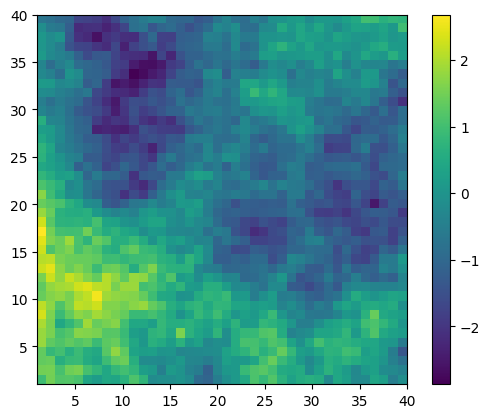

In [73]:
plt.imshow(points.reshape((s.sqrt_n, s.sqrt_n)), extent = [1,s.sqrt_n,1,s.sqrt_n])
plt.colorbar()
plt.show()

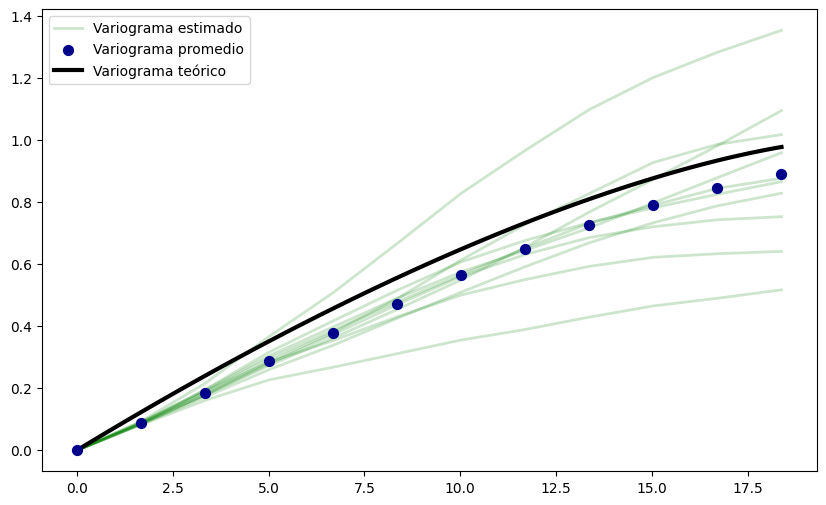

In [74]:
h_max = s.distances_matrix.max()/3
n_lags = int(np.ceil(2 * np.log2(s.sqrt_n) + 1))
n_simulates = 10

x = np.linspace(0,h_max,100)

cov = SpatialFieldSimulator.askey(alpha=alpha,beta=beta,nu=nu)
prom=np.zeros(n_lags)

plt.figure(figsize=(10,6))
for _ in range(n_simulates-1):
    points = s.simulate(method = 'cholesky', model = 'askey', alpha = alpha, beta = beta, nu = nu)
    lags, semivariograms = s.variogram(points, h_max, n_lags)
    prom += semivariograms
    plt.plot(lags, semivariograms, c='g', lw=2, alpha=0.2)
    
points = s.simulate(method = 'cholesky', model = 'askey', alpha = alpha, beta = beta, nu = nu)
lags, semivariograms = s.variogram(points, h_max, n_lags)
prom += semivariograms
plt.plot(lags, semivariograms, c='g', lw=2, alpha=0.2, label='Variograma estimado')

plt.scatter(lags, prom/n_simulates, s=50, c='darkblue', zorder=3, label='Variograma promedio')
plt.plot(x, cov(0)-cov(x), lw=3, label='Variograma teórico', c='k', zorder=2)
plt.legend();